# KNN Kd-tree algorithm on Amazon fine food dataset

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
To perform KNN kd-tree algorithm on different vectors like BOW, Tf-idf, Avg-W2vec & Tf-idf_W2vec.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


#Importing Cleaned & Deduped dataset
# using the SQLite Table to read data.
con = sqlite3.connect('C:/Users/deepak/Documents/Applied AI assignments/3. Tsne on Amazon fine food/final.sqlite') 

C:\Users\deepak\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
Data = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

In [3]:
#Doing Time based splitting
data_amazon_fine=Data.sort_values("Time",ascending = True)

In [4]:
#Using sample 25K points for doing KNN
# 17.5K points for train and 7.5K for test
train_data=data_amazon_fine.iloc[:17500]
test_data=data_amazon_fine.iloc[17500:25000]

In [5]:
train_data.shape

(17500, 12)

In [6]:
train_data['Score'].value_counts()

positive    15604
negative     1896
Name: Score, dtype: int64

In [7]:
test_data.shape

(7500, 12)

In [8]:
test_data['Score'].value_counts()

positive    6637
negative     863
Name: Score, dtype: int64

In [9]:
#Train data
y_train = train_data['Score']
x_train = train_data['CleanedText']

#Test data
y_test = test_data['Score']
x_test = test_data['CleanedText'] 

#### KD-Tree

#### Binary BOW

In [10]:
count_vect = CountVectorizer(binary=True)

#Train data
vocabulary = count_vect.fit(x_train) #in scikit-learn
Bow_x_train= count_vect.transform(x_train)
print("the type of count vectorizer ",type(Bow_x_train))
print("the shape of out text BOW vectorizer ",Bow_x_train.get_shape())
print("the number of unique words ", Bow_x_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17500, 17367)
the number of unique words  17367


In [11]:
#Test data
Bow_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(Bow_x_test))
print("the shape of out text BOW vectorizer ",Bow_x_test.get_shape())
print("the number of unique words ", Bow_x_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7500, 17367)
the number of unique words  17367


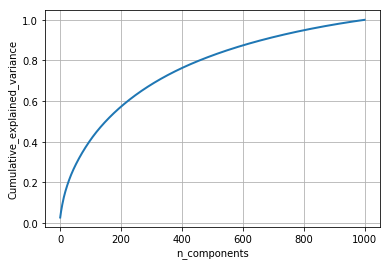

In [14]:
#Making datasets dense for truncated svd
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD()

#Fitting SVD on training data
svd.n_components = 1000
svd_Bow_x_train = svd.fit_transform(Bow_x_train)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the svd spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

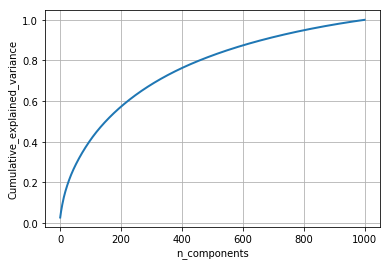

In [15]:
#Transforming test data
svd_Bow_x_test = svd.transform(Bow_x_test)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the svd spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\Users\deepak\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Running Gridsearch CV 

In [89]:
myList = list(range(0,50))
k_range=list(filter(lambda x: x % 2 != 0, myList))
weight_options=['uniform','distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

# instantiate and fit the grid
grid = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'), param_grid, cv=5, scoring='accuracy', return_train_score=False,n_jobs=-1)


{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49], 'weights': ['uniform', 'distance']}


#### Fitting gridsearch cv on BOW

In [86]:
grid.fit(svd_Bow_x_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.8928571428571429
{'n_neighbors': 11, 'weights': 'distance'}


In [80]:
# KNN WITH KDTREE ALGO 

knn_optimal = KNeighborsClassifier(n_neighbors=,algorithm='kd_tree',weights='distance',n_jobs=1)

# fitting the model
knn_optimal.fit(svd_Bow_x_train, y_train)

# predict the response
pred_svd_Bow = knn_optimal.predict(svd_Bow_x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred_svd_Bow) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (11, acc))


The accuracy of the knn classifier for k = 11 is 88.666667%


-------------------- Confusion matrix --------------------


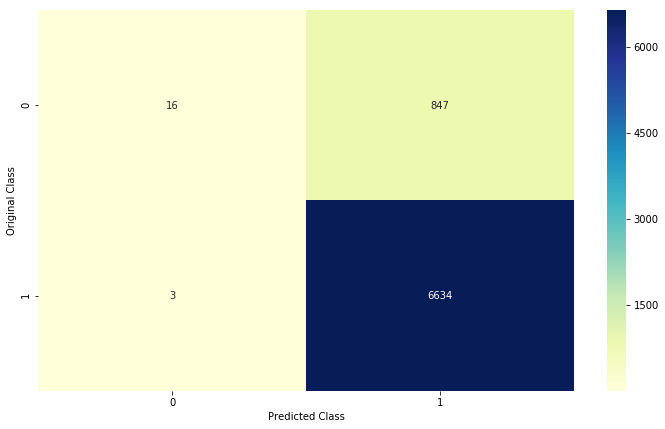

In [98]:
#Confusion matrix
CM=confusion_matrix(y_test, pred_svd_Bow)
labels = [0,1]
print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(CM, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()


### Tf-Idf

In [32]:
#Initiating Vectorizer
count_vect = CountVectorizer(ngram_range=(1,2))

#Train data
vocabulary = count_vect.fit(x_train)
Tfidf_x_train= count_vect.transform(x_train)
print("the type of count vectorizer ",type(Tfidf_x_train))
print("the shape of out text BOW vectorizer ",Tfidf_x_train.get_shape())
print("the number of unique words ", Tfidf_x_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17500, 333906)
the number of unique words  333906


In [33]:
#Test data
Tfidf_x_test= count_vect.transform(x_test)
print("the type of co unt vectorizer ",type(Tfidf_x_test))
print("the shape of out text BOW vectorizer ",Tfidf_x_test.get_shape())
print("the number of unique words ", Tfidf_x_test.get_shape()[1])

the type of co unt vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7500, 333906)
the number of unique words  333906


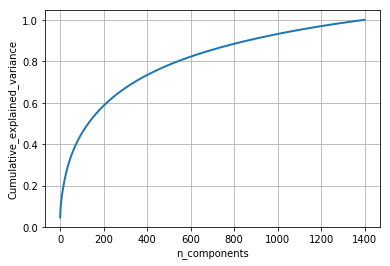

In [35]:
#Making datasets dense by truncated svd
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD()


#On training data
svd.n_components = 1400
svd_Tfidf_x_train = svd.fit_transform(Tfidf_x_train)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the svd spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

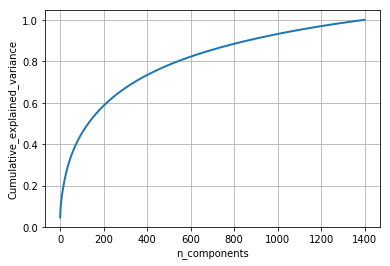

In [36]:
#On test data
svd_Tfidf_x_test = svd.transform(Tfidf_x_test)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the svd spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


#### Fitting Gridsearch CV on Tf-Idf

In [90]:
grid.fit(svd_Tfidf_x_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)


0.8930857142857143
{'n_neighbors': 11, 'weights': 'distance'}


In [93]:
# KNN WITH KDTREE ALGO 

knn_optimal = KNeighborsClassifier(n_neighbors=11,algorithm='kd_tree',weights='distance',n_jobs=1)

# fitting the model
knn_optimal.fit(svd_Tfidf_x_train, y_train)

# predict the response
pred_tfidf = knn_optimal.predict(svd_Tfidf_x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (11, acc))


The accuracy of the knn classifier for k = 11 is 88.666667%


-------------------- Confusion matrix --------------------


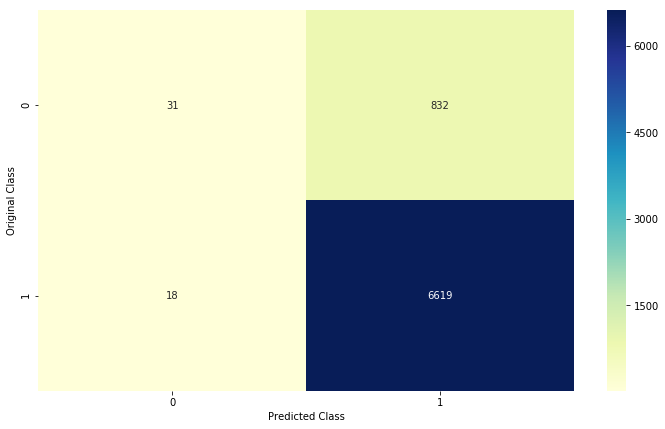

In [99]:
#Confusion matrix
CM=confusion_matrix(y_test, pred_tfidf)
labels = [0,1]
print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(CM, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()


#### W2V

In [20]:
#W2V Training data
i=0
list_of_sent_train=[]
for sent in train_data['CleanedText'].values:
    list_of_sent_train.append(sent.split())

In [21]:
print(train_data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [22]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=6)

In [23]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  5956
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'turn', 'whole', 'school', 'purchas', 'children']


In [24]:
#W2V Test data
i=0
list_of_sent_test=[]
for sent in test_data['CleanedText'].values:
    list_of_sent_test.append(sent.split())

#### Avg W2V 

In [25]:
#Train data
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_avgw2v.append(sent_vec)
print(len(sent_vectors_train_avgw2v))
print(len(sent_vectors_train_avgw2v[0]))

17500
50


In [26]:
#Test data
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_avgw2v.append(sent_vec)
print(len(sent_vectors_test_avgw2v))
print(len(sent_vectors_test_avgw2v[0]))

7500
50


#### Fitting Gridsearch CV on Avg-W2V

In [91]:
grid.fit(sent_vectors_train_avgw2v, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)


0.8972
{'n_neighbors': 17, 'weights': 'distance'}


In [94]:
# KNN WITH KDTREE ALGO 

knn_optimal = KNeighborsClassifier(n_neighbors=17,algorithm='kd_tree',weights='distance',n_jobs=1)

# fitting the model
knn_optimal.fit(sent_vectors_train_avgw2v, y_train)

# predict the response
pred_avgw2v = knn_optimal.predict(sent_vectors_test_avgw2v)

# evaluate accuracy
acc = accuracy_score(y_test, pred_avgw2v) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (17, acc))


The accuracy of the knn classifier for k = 17 is 88.933333%


-------------------- Confusion matrix --------------------


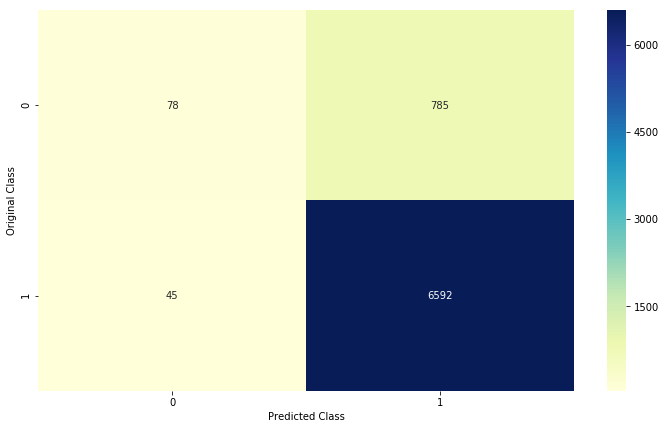

In [100]:
#Confusion matrix
CM=confusion_matrix(y_test, pred_avgw2v)
labels = [0,1]
print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(CM, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()


#### Tfidf_w2v

In [28]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocabulary = tf_idf_vect.fit(train_data['CleanedText'])
final_tf_idf= tf_idf_vect.transform(train_data['CleanedText'])

# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names()# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

In [29]:
tfidf_w2v_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_train.append(sent_vec)
    row += 1

In [30]:
final_tf_idf= tf_idf_vect.transform(test_data['CleanedText'])

tfidf_w2v_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_test.append(sent_vec)
    row += 1

#### Fitting Gridsearch CV on Tfidf-W2V

In [92]:
grid.fit(tfidf_w2v_sent_vectors_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.8946857142857143
{'n_neighbors': 47, 'weights': 'distance'}


In [95]:
 # KNN WITH KDTREE ALGO 

knn_optimal = KNeighborsClassifier(n_neighbors=47,algorithm='kd_tree',weights='distance',n_jobs=-1)

# fitting the model 
knn_optimal.fit(tfidf_w2v_sent_vectors_train, y_train)

# predict the response
pred_tfidf_w2v = knn_optimal.predict(tfidf_w2v_sent_vectors_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred_tfidf_w2v) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (47, acc))


The accuracy of the knn classifier for k = 47 is 88.773333%


-------------------- Confusion matrix --------------------


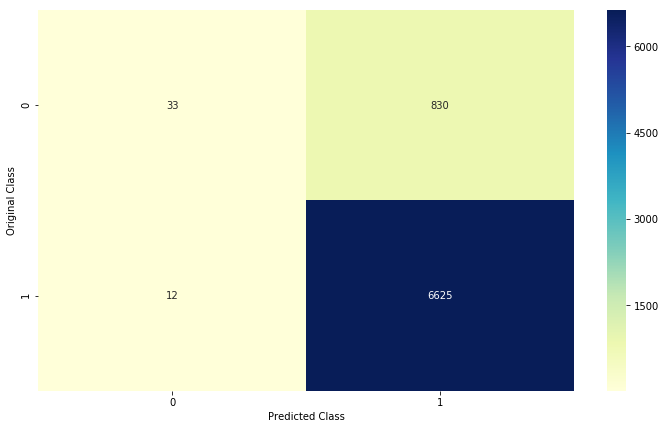

In [101]:
#Confusion matrix
CM=confusion_matrix(y_test, pred_tfidf_w2v)

labels = [0,1]6625
print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(CM, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
